# Bank Account Fraud Detection

## Luke DiPerna

### January 2023



Photo by <a href="https://unsplash.com/@rupixen?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">rupixen.com</a> on <a href="https://unsplash.com/s/photos/credit-card?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Project Goal
***
The goal of this project is to accurately and responsibly predict fraudulent bank account applications. The stakeholder is the Office of the Comptroller of the Currency (OCC), an independent bureau of the US Department of the Treasury. The OCC is responsible for regulating and supervising all national banks.

With the rise in reliance on machine learning models to detect things like fraudulent bank account applications, there is growing concern about the bias that is often "built-in" to these models. (See examples here, here, here, etc.). The OCC, whose mission is in part to be a supervisor who "promotes a vibrant and diverse banking system that benefits consumers, communities, businesses, and the U.S. economy" ([link](https://www.occ.gov/about/index-about.html)), wishes to examine machine learning models and practices that will balance the needs of the banks while ensuring that consumers are not subject to discrimination and unfair treatment. In doing so, they can begin to establish industry standards to ensure that banks implement non-discriminatory practices.

To do this, certain protected classes/information will be be anonymized. Additionally, since the dataset is heavily imbalanced, accuracy is not a suitable metric. Instead, models will be judged by their precision (true positive rate) at a set false positive rate. The results must also not show bias towards any particular group among the protected classes. For a more detailed description of how the data and methods will account for this, please see ________________.

## Table of Contents

## Data

## Methods/Metrics

## Exploratory Data Analysis (EDA)

Since the dataset is mostly cleaned already, there is not much pre-processing or preparation needed. Instead, I will focus on gaining a solid understanding of what is in the dataset, and how to most effectively utilize it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
seed = 99
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
fpr_max = 0.05

# with open('clf.pickle', 'rb') as f:
#     clf = pickle.load(f)

In [2]:
df = pd.read_csv('bank_account_fraud_dataset.csv')
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

As expected, the dataset has no missing values. There are several `object` columns, however, and these need to be changed into numeric dtypes before I can train the models. I will examine the column values before transforming them so I know what kind of information is contained before it becomes abstracted.

In [4]:
for column in df.select_dtypes('object').columns:
    print(df[column].value_counts())

AB    370554
AA    258249
AC    252071
AD    118837
AE       289
Name: payment_type, dtype: int64
CA    730252
CB    138288
CF     44034
CC     37758
CD     26522
CE     22693
CG       453
Name: employment_status, dtype: int64
BC    372143
BB    260965
BA    169675
BE    169135
BD     26161
BF      1669
BG       252
Name: housing_status, dtype: int64
INTERNET    992952
TELEAPP       7048
Name: source, dtype: int64
other        342728
linux        332712
windows      263506
macintosh     53826
x11            7228
Name: device_os, dtype: int64


`payment_type`, `employment_status`, and `housing_status` have already been anonymized since they contain protected information, as discussed HERE.  Now that I know what kind of information each feature contains, I will use an encoder to change each column into interger values.

In [5]:
for column in df.select_dtypes('object').columns:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  int32  
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

As seen above, all of the columns are now numeric, and can be used to train the models. I will now examine one of the transformed columns to demonstrate how the values have been changed, and examine the distribution in the target column: `fraud_boolean`, which is the feature the models will attempt to predict.

In [6]:
df['payment_type'].value_counts()

1    370554
0    258249
2    252071
3    118837
4       289
Name: payment_type, dtype: int64

In [7]:
df['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

The data is highly imbalanced, so I will employ undersampling to create a more balanced training dataset. But first, I want to look at the distribution of all features in the set.

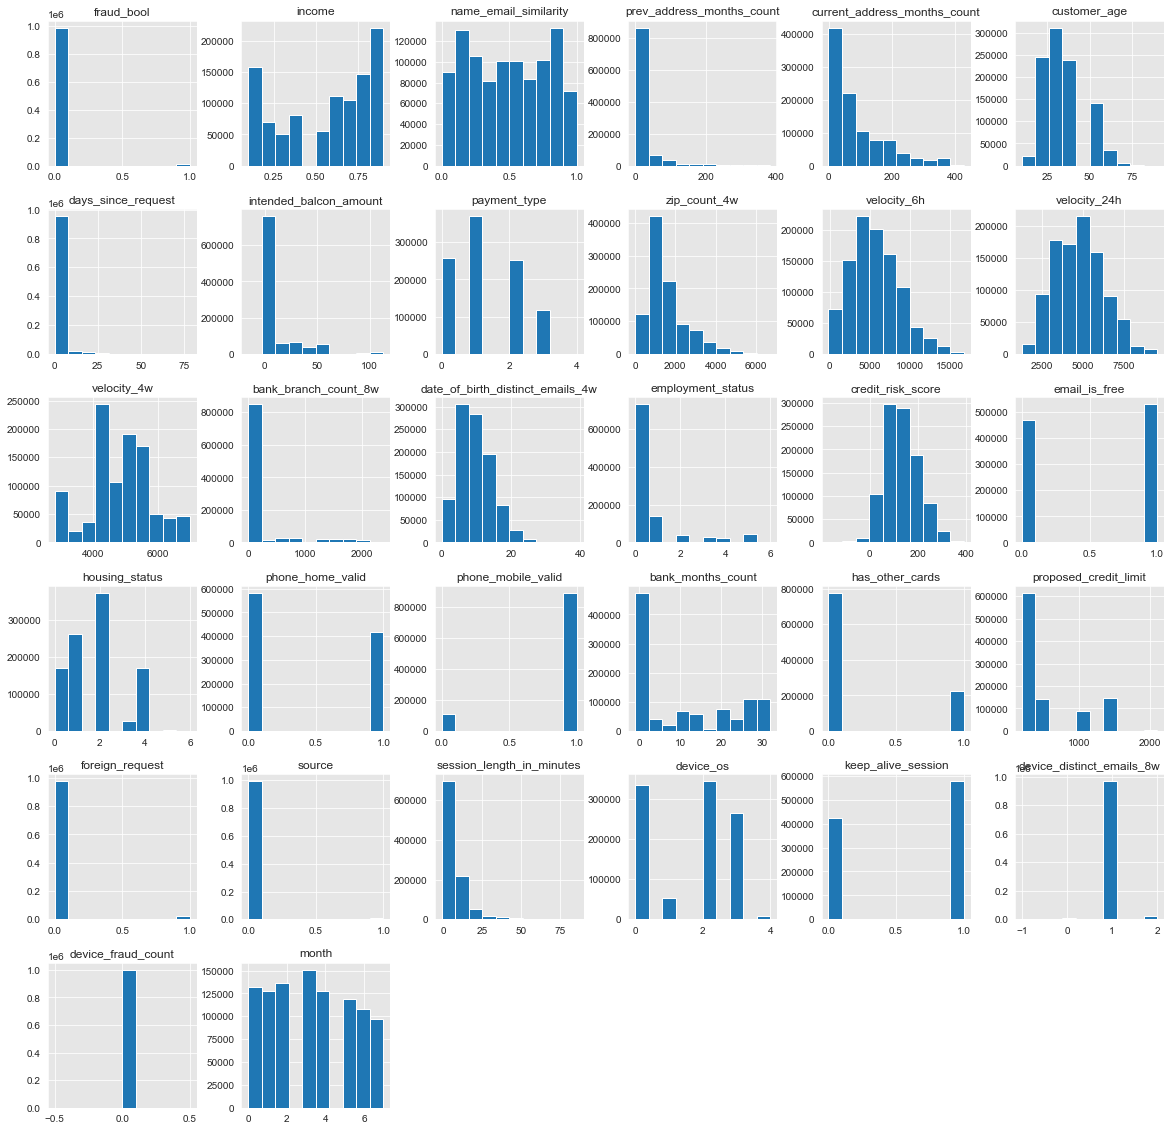

In [8]:
df.hist(figsize=(20,20));

Some of the feature values are not immediately comprehensible, but a detailed breakdown of each of the features can be found HERE. I want to check the correlation between the target variable and the other features. Because of the imbalanced data, the correlation scores should all be pretty low, but there may be a few features that stand out. I will also drop `device_fraud_count` since it contains only zeroes.

In [9]:
df.drop('device_fraud_count', axis=1, inplace=True)
df.corr()['fraud_bool'].sort_values(ascending=False)

fraud_bool                          1.000000
credit_risk_score                   0.070624
proposed_credit_limit               0.068907
customer_age                        0.062959
device_os                           0.057834
income                              0.045079
device_distinct_emails_8w           0.035704
current_address_months_count        0.033701
payment_type                        0.028304
email_is_free                       0.027758
foreign_request                     0.016885
month                               0.013250
session_length_in_minutes           0.008999
zip_count_4w                        0.005212
source                              0.003922
days_since_request                  0.000567
bank_months_count                  -0.003222
velocity_24h                       -0.011183
velocity_4w                        -0.011536
bank_branch_count_8w               -0.011577
phone_mobile_valid                 -0.013180
velocity_6h                        -0.016892
employment

As expected, most of the features are minimally correlated (`corr` < 0.05), but there are a few features on the positive and negative end that indicate a slightly stronger relationship. `credit_risk_score` and `housing_status` both have an absolute correlation of over 0.07, indicating that they may be more useful in determining fraud. This is an incredibly simplistic metric, but gives me a few things to consider as I move in to deeper analysis.

Next, I will prepare the data for modeling by splitting the data into training and test splits, and performing undersampling on the training set. Undersampling will achieve 2 goals:

1. It allows the models to place more importance on identifying the fraudulent applications.
2. It reduces the overall number of datapoints. Due to technical limitations and the size of the original dataset, I am unable to build models in a reasonable fashion using the entire dataset.

Ideally, I could instead use oversampling on the positive class to solve issue 1. However, the would greatly exacerbate the second issue. I will leave the test set unchanged, however.

In [10]:
X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']
# train/test split determined by the month in which the data was gathered.
X_train = X[X['month'] < 6]
X_test = X[X['month'] >= 6]
y_train = y[X['month'] < 6]
y_test = y[X['month'] >= 6]

In [11]:
y_train.value_counts()

0    786838
1      8151
Name: fraud_bool, dtype: int64

In [12]:
y_test.value_counts()

0    202133
1      2878
Name: fraud_bool, dtype: int64

In [13]:
under_sampler = RandomUnderSampler(sampling_strategy=.1, random_state=seed)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

y_train.value_counts()

0    81510
1     8151
Name: fraud_bool, dtype: int64

## Modeling
***
Now that the data is prepared, I will iteratively create a series of models as I attempt to refine and improve upon each successive model. As mentioned above, I will be using recall, also known as the true positive rate (TPR) at a set false positive rate (FPR) to measure the effectiveness of each model. In this case, the FPR is 5%, which means that each of the models I create will have a false positive rate of 5%. From there, I will try to maximize the true positive rate.

Since this is a classification task, I will begin with a relatively simple logistic regression model as my baseline. I will use this baseline model to compare against future models.

After creating my baseline model, I will create K-Nearest Neighbors (KNN) models as well as Random Forest (RF) models. I go into more detail about the relative merits of each down below, but both are traditionally reliable methods for this type of classification problem. 

### Custom Functions

I will create several functions to help me measure and compare each model. The functions will include:

- custom scorer
- `ModelEval` class

The custom scorer will use `custom_tpr_func` to calculate the Receving Operating Characteristic (ROC) curve and return the TPR at the set FPR of 0.05.

The `ModelEval` class will allow me to measure the key metrics for each model and compare them to previous models. The class includes methods for finding the cross-validation score, plotting the ROC curve, building a confusion matrix, and returning the classification report.

In [14]:
# create dataframe to compare various models
score_df = pd.DataFrame(columns = ['model name', 'tpr', 'roc_auc'])

In [15]:
# scoring function to return the tpr at a set fpr
def custom_tpr_func(y_true, y_preds, fpr_max=fpr_max):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_preds)
    
#     score_fpr = fpr[fpr<fpr_max][-1]
    score_tpr = tpr[fpr<fpr_max][-1]
#     score_threshold = thresholds[fpr<fpr_max][-1]
    
    return score_tpr

# custom scorer to use in cross validation
tpr_scorer = make_scorer(custom_tpr_func, greater_is_better=True, needs_threshold=True)

In [16]:
class ModelEval():
    '''
    
    '''
    
    def __init__(self, model, model_name, score_df, fpr_max=0.05):
        
        self._model = model
        self._model_name = model_name
        self._score_df = score_df
        self._fpr_max = fpr_max
    
    def cv_proba(self, X_train, y_train, method, cv=5):
        
#         self._X_train = X_train
#         self._y_train = y_train
        
        self._proba = cross_val_predict(self._model, X_train, y_train, cv=5, method=method)
        
        if method == 'decision_function':
            self._fpr, self._tpr, self._thresholds = roc_curve(y_train, self._proba)
        else:
            self._fpr, self._tpr, self._thresholds = roc_curve(y_train, self._proba[:,1])
        
        self._roc_auc = auc(self._fpr, self._tpr)
        
        self._score_fpr = self._fpr[self._fpr<self._fpr_max][-1]
        self._score_tpr = self._tpr[self._fpr<self._fpr_max][-1]
        self._score_threshold = self._thresholds[self._fpr<self._fpr_max][-1]
        
        idx = score_df.shape[0]
        score_df.loc[idx] = [self._model_name, self._score_tpr, self._roc_auc]
           
    def test_proba(self, X_train, y_train, X_test, y_test, method):
        
        self._model.fit(X_train, y_train)
        
        if method == 'decision_function':
            self._test_proba = self._model.decision_function(X_test)
            self._test_fpr, self._test_tpr, self._test_thresholds = roc_curve(y_test, self._test_proba)
        elif method == 'predict_proba':
            self._test_proba = self._model.predict_proba(X_test)
            self._test_fpr, self._test_tpr, self._test_thresholds = roc_curve(y_test, self._test_proba[:,1])
        
        self._test_roc_auc = auc(self._test_fpr, self._test_tpr)
        
        self._test_score_fpr = self._test_fpr[self._test_fpr<self._fpr_max][-1]
        self._test_score_tpr = self._test_tpr[self._test_fpr<self._fpr_max][-1]
        self._test_score_threshold = self._test_thresholds[self._test_fpr<self._fpr_max][-1]
    
    def plot_roc(self, test_set=False):
        
        if test_set==False:
            
            horiz_offset = self._score_fpr*0.2
            
            plt.figure(figsize=(10, 8))
            lw = 2
            plt.plot(self._fpr, self._tpr, color='darkorange', lw=lw, label=f'ROC AUC = {round(self._roc_auc, 2)}')
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.plot(self._score_fpr, self._score_tpr, marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.yticks([i/20.0 for i in range(21)])
            plt.xticks([i/20.0 for i in range(21)])
            plt.text(x=self._score_fpr + horiz_offset, y=self._score_tpr, s=f'TPR = {round(self._score_tpr, 2)}', weight='semibold')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{self._model_name} ROC Curve (CV=5)')
            plt.legend(loc='lower right')
            return plt.show()
        
        elif test_set==True:
            
            horiz_offset = self._test_score_fpr*0.2
            
            plt.figure(figsize=(10, 8))
            lw = 2
            plt.plot(self._test_fpr, self._test_tpr, color='darkorange', lw=lw, label=f'ROC AUC = {round(self._test_roc_auc, 2)}')
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.plot(self._test_score_fpr, self._test_score_tpr, marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.yticks([i/20.0 for i in range(21)])
            plt.xticks([i/20.0 for i in range(21)])
            plt.text(x=self._test_score_fpr + horiz_offset, y=self._test_score_tpr, s=f'TPR = {round(self._test_score_tpr, 2)}', weight='semibold')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{self._model_name} ROC Curve')
            plt.legend(loc='lower right')
            return plt.show()
    
#     def cm(self):

#         cv_preds = cross_val_predict(lr, X_train, y_train, cv=5, method='predict')

#         cm = confusion_matrix(self._y_test, self._proba)
#         display = ConfusionMatrixDisplay(confusion_matrix=cm)
#         display.plot(cmap='cividis')
#         plt.grid(False);
        
#     def class_report(self, y, proba):
#         print(classification_report(y, proba))

### Baseline Model: Logistic Regression

Logistic regression is good choice for a baseline model because of its relative speed, incomplexity, and interpretability. It uses a logistic function to model the target variable, which in this case is whether or not the bank account application is fraudulent. Logistic regression is ideal for modeling this type of binary classification, and calculates the probability that an event will happen or not (i.e. fraudulent or not).

In [17]:
# high C value to prevent regularization
lr = LogisticRegression(fit_intercept=False, C=1e15, solver='liblinear')

In [18]:
lr_eval = ModelEval(model=lr, model_name='logreg', score_df=score_df)

In [19]:
lr_eval.cv_proba(X_train, y_train, method='decision_function', cv=5)

In [20]:
lr_eval._score_tpr

0.39246718194086616

In [21]:
score_df

,model name,tpr,roc_auc
0,logreg,0.392467,0.827328


The tpr score is quite low. I will attempt it again with scaled data and regularization.

In [22]:
lr_scale_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(fit_intercept=False, solver='liblinear'))
                      ])
lr_scaled_eval = ModelEval(model=lr_scale_pipe, model_name='logreg_scaled', score_df=score_df)

In [23]:
lr_scaled_eval.cv_proba(X_train, y_train, method='decision_function', cv=5)

In [24]:
lr_scaled_eval._score_tpr

0.40338608759661393

In [25]:
score_df

,model name,tpr,roc_auc
0,logreg,0.392467,0.827328
1,logreg_scaled,0.403386,0.835660


Only a slight improvement from the previous model, but this will be the baseline for our other, more complex models.

### K-Nearest Neighbors (KNN)

KNN will be the next modeling method I attempt. KNN is capable of modeling multi-classification problems, but in this instance it will will be used to determine the binary classification of fraudulent or not. For any given datapoint, it uses the proximity of nearby datapoints to determine the proper classification. This is a fairly intensive method, and given the number of datapoints I am using, will require a good bit of time and resources to model. However, the added complexity will hopefully lead to a far more reliable model.

I will begin with a KNN model using the default hyperparameters, then perform a grid search to tune the hyperparameters. I must first scale the data, since the distance between datapoints is crucial to the success of the model.

In [26]:
knn = KNeighborsClassifier()
scale_pipe = Pipeline([('scaler', StandardScaler()),
                       ('knn', knn)
                      ])

In [27]:
knn_scaled_eval = ModelEval(scale_pipe, 'knn_scaled', score_df)
knn_scaled_eval.cv_proba(X_train, y_train, method='predict_proba', cv=5)

In [28]:
knn_scaled_eval._score_tpr

0.16317016317016317

In [29]:
score_df

,model name,tpr,roc_auc
0,logreg,0.392467,0.827328
1,logreg_scaled,0.403386,0.835660
2,knn_scaled,0.163170,0.705033


The results are underwhelming, but I was using default hyperparameters. Now for hyperparameter tuning. I initially tested more hyperparameters, including `weights`: ['uniform', 'distance'] and `p`: [1,2,3]. However, `weight=distance` and `p=3` were consistently outperformed by the others, so to conserve time and computing power, I have limited this grid search to only test the relevant metrics.

In [30]:
knn_param_grid = {'knn__n_neighbors': [5,7,9], 'knn__p': [1, 2]}
knn_gs = GridSearchCV(scale_pipe, knn_param_grid, cv=5, scoring=tpr_scorer)
knn_gs.fit(X_train, y_train)
knn_gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7, p=1))])

In [31]:
pd.DataFrame(knn_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.903436,0.147624,105.954075,2.511737,5,1,"{'knn__n_neighbors': 5, 'knn__p': 1}",0.177192,0.156442,0.144172,0.162577,0.195706,0.167218,0.017775,5
1,7.104679,0.228971,107.006625,3.228734,5,2,"{'knn__n_neighbors': 5, 'knn__p': 2}",0.187615,0.150920,0.112883,0.167485,0.196933,0.163167,0.029782,6
2,7.223848,0.339587,111.796507,6.521179,7,1,"{'knn__n_neighbors': 7, 'knn__p': 1}",0.278970,0.259509,0.235583,0.263804,0.310429,0.269659,0.024688,1
3,7.621810,0.230755,108.051169,1.997785,7,2,"{'knn__n_neighbors': 7, 'knn__p': 2}",0.299203,0.250920,0.201840,0.268098,0.317178,0.267448,0.040148,2
4,6.785360,0.370928,104.117486,0.789851,9,1,"{'knn__n_neighbors': 9, 'knn__p': 1}",0.239730,0.227607,0.192025,0.237423,0.272393,0.233836,0.025773,3
5,6.634470,0.173071,102.968926,2.078042,9,2,"{'knn__n_neighbors': 9, 'knn__p': 2}",0.266708,0.214724,0.170552,0.231902,0.277301,0.232237,0.038290,4


The best performing model hyperparameters are `n_neighbors=7` and `p=1`. I will use these for the final knn model, `knn_best`. 

In [32]:
knn_best = KNeighborsClassifier(n_neighbors=7, p=1)

knn_best_pipe = Pipeline([('scaler', StandardScaler()),
                       ('knn', knn_best)
                    ])

### Random Forests (RF)

The final modeling technique I will use is Random Forests. This is an ensemble method that randomly creates many decision trees and aggregates them to determine the classification of each datapoint. The results are somewhat more opaque than the other models, but may be able to outperform them.

In [33]:
rf = RandomForestClassifier()
rf_eval = ModelEval(rf, 'rf', score_df)
rf_eval.cv_proba(X_train, y_train, method='predict_proba', cv=5)

In [34]:
rf_eval._score_tpr

0.35234940498098394

In [35]:
score_df

,model name,tpr,roc_auc
0,logreg,0.392467,0.827328
1,logreg_scaled,0.403386,0.835660
2,knn_scaled,0.163170,0.705033
3,rf,0.352349,0.822451


Again, the results are far from impressive, but I will now tune hyperparameters in an attempt to improve upon the model.

In [36]:
rf_param_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 10, 20],
                 'max_features': ['sqrt', None]}
rf_gs = GridSearchCV(rf, rf_param_grid, cv=5, scoring=tpr_scorer)
rf_gs.fit(X_train, y_train)
rf_gs.best_estimator_

RandomForestClassifier(max_depth=10, max_features='sqrt')

In [37]:
pd.DataFrame(rf_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.956322,0.109057,0.295961,0.009356,gini,None,sqrt,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.406499,0.339877,0.318405,0.295092,0.352147,0.342404,0.037480,4
1,93.188834,0.526710,0.295454,0.007418,gini,None,None,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.210300,0.323926,0.306748,0.279141,0.212270,0.266477,0.047280,10
2,9.849318,0.137767,0.182557,0.006241,gini,10,sqrt,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.514408,0.368098,0.327607,0.303681,0.467485,0.396256,0.081375,1
3,53.523838,0.528818,0.161378,0.006554,gini,10,None,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.307174,0.363190,0.326380,0.300613,0.250307,0.309533,0.036758,7
4,14.598726,0.176299,0.279493,0.012487,gini,20,sqrt,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.400368,0.354601,0.334356,0.302454,0.385276,0.355411,0.035104,3
5,86.843734,0.459797,0.277095,0.010169,gini,20,None,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.227468,0.352147,0.322699,0.301227,0.234969,0.287702,0.048928,9
6,18.071952,0.100977,0.276030,0.009088,entropy,None,sqrt,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.412017,0.328834,0.309816,0.252147,0.365031,0.333569,0.053591,6
7,92.799331,1.268903,0.254485,0.017144,entropy,None,None,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.234825,0.332515,0.305521,0.218405,0.182209,0.254695,0.055867,12
8,13.029615,0.283120,0.192486,0.006967,entropy,10,sqrt,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.510116,0.373006,0.328221,0.263190,0.435583,0.382023,0.085292,2
9,70.632977,1.287560,0.185332,0.007026,entropy,10,None,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.321888,0.358896,0.316564,0.225767,0.224540,0.289531,0.054551,8


`criterion='gini'` and `max_features='sqrt'` consistently outperform `criterion='entropy'`, and `max_features='sqrt'`, so for the next gridsearch I will focus on `max_depth`.

In [38]:
rf_param_grid = {'criterion': ['gini'],
                 'max_depth': [4, 5, 6, 7, 10],
                 'max_features': ['sqrt']}
rf_gs = GridSearchCV(rf, rf_param_grid, cv=5, scoring=tpr_scorer)
rf_gs.fit(X_train, y_train)
rf_gs.best_estimator_

RandomForestClassifier(max_depth=6, max_features='sqrt')

In [39]:
pd.DataFrame(rf_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.496659,0.103354,0.100407,0.010742,gini,4,sqrt,"{'criterion': 'gini', 'max_depth': 4, 'max_fea...",0.511956,0.352761,0.346012,0.356442,0.497546,0.412943,0.075173,4
1,5.653333,0.175627,0.103681,0.006740,gini,5,sqrt,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.514408,0.357669,0.345399,0.355828,0.493252,0.413311,0.074328,3
2,6.714142,0.463750,0.121563,0.005804,gini,6,sqrt,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.533415,0.366871,0.347853,0.361963,0.525153,0.427051,0.083747,1
3,7.247933,0.084993,0.131138,0.007719,gini,7,sqrt,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.521153,0.377914,0.350920,0.328221,0.530061,0.421654,0.086369,2
4,10.017783,0.262504,0.183506,0.009992,gini,10,sqrt,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.500307,0.368712,0.342331,0.336196,0.450920,0.399693,0.064853,5


In [40]:
rf_best = RandomForestClassifier(criterion='gini', max_depth=5, max_features='sqrt')

## Model Evaluation

In [41]:
lr_scaled_eval.test_proba(X_train, y_train, X_test, y_test, method='decision_function')

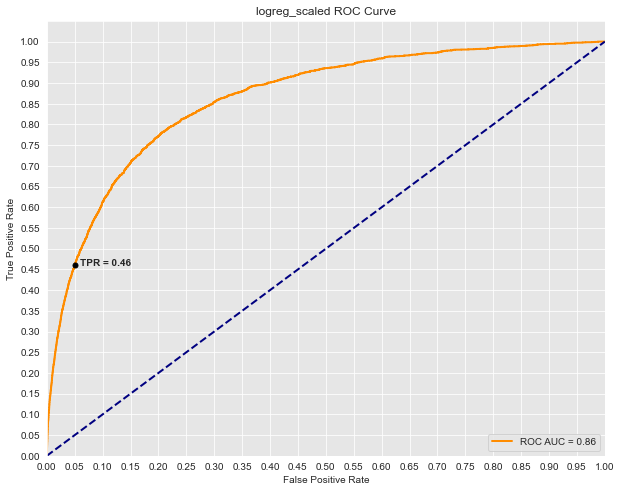

In [42]:
lr_scaled_eval.plot_roc(test_set=True)

In [43]:
knn_best_eval = ModelEval(knn_best_pipe, 'best_knn', score_df)
knn_best_eval.test_proba(X_train, y_train, X_test, y_test, method='predict_proba')

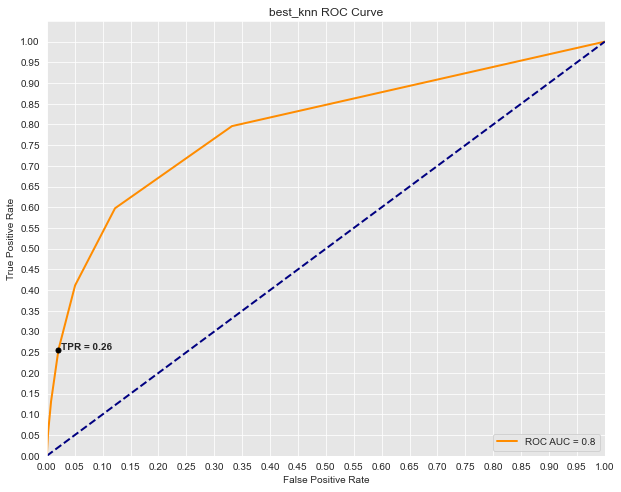

In [44]:
knn_best_eval.plot_roc(test_set=True)

In [45]:
rf_best_eval = ModelEval(rf_best, 'best rf', score_df)
rf_best_eval.test_proba(X_train, y_train, X_test, y_test, method='predict_proba')

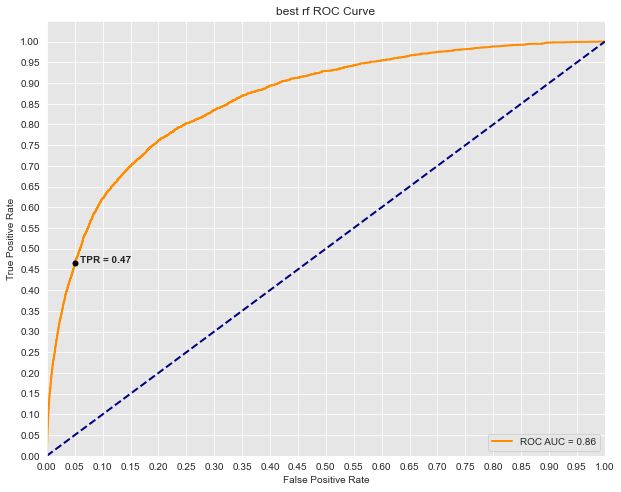

In [46]:
rf_best_eval.plot_roc(test_set=True)

### Aequitas Bias and Fairness Metrics

In [ ]:
# !pip install aequitas

In [ ]:
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [ ]:
bias_groups = ['income', 'customer_age', 'employment_status']
logreg_preds_df = pd.Series(cv_preds, name='score')
logreg_aq_train = pd.concat([X_train[bias_groups], y_train, logreg_preds_df], axis=1)
logreg_aq_train.rename(columns={'fraud_bool': 'label_value'}, inplace=True)
logreg_aq_train

In [ ]:
logreg_aq_train, _ = preprocess_input_df(logreg_aq_train)

In [ ]:
logreg_aq_train

In [ ]:
g = Group()
logreg_xtab, _ = g.get_crosstabs(logreg_aq_train)

In [ ]:
aqp = Plot()
fpr = aqp.plot_group_metric(logreg_xtab, 'fpr', ax_lim=0.4)

In [ ]:
def fprplot(df):
    g = Group()
    xtab, _ = g.get_crosstabs(df)
    
    aqp = Plot()
    fpr = aqp.plot_group_metric(xtab, 'fpr')

## Conclusion